In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
import numpy as np

In [2]:
# Load the SAM model
model_type = "vit_h"  # or vit_l, vit_b
checkpoint_path = "model checkpoints/sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.eval()  # Set the model to evaluation mode

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [3]:
# Initialize the predictor
predictor = SamPredictor(sam)

In [68]:
# Load your image
image_path = "data/pole/6.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

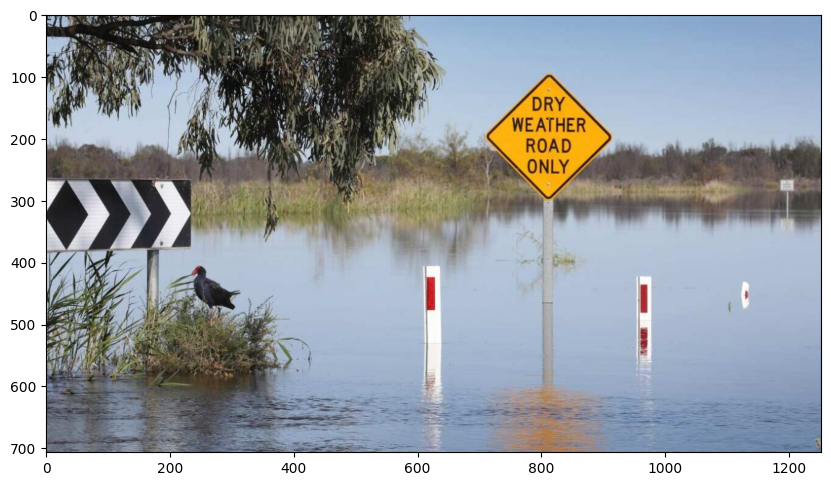

In [69]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

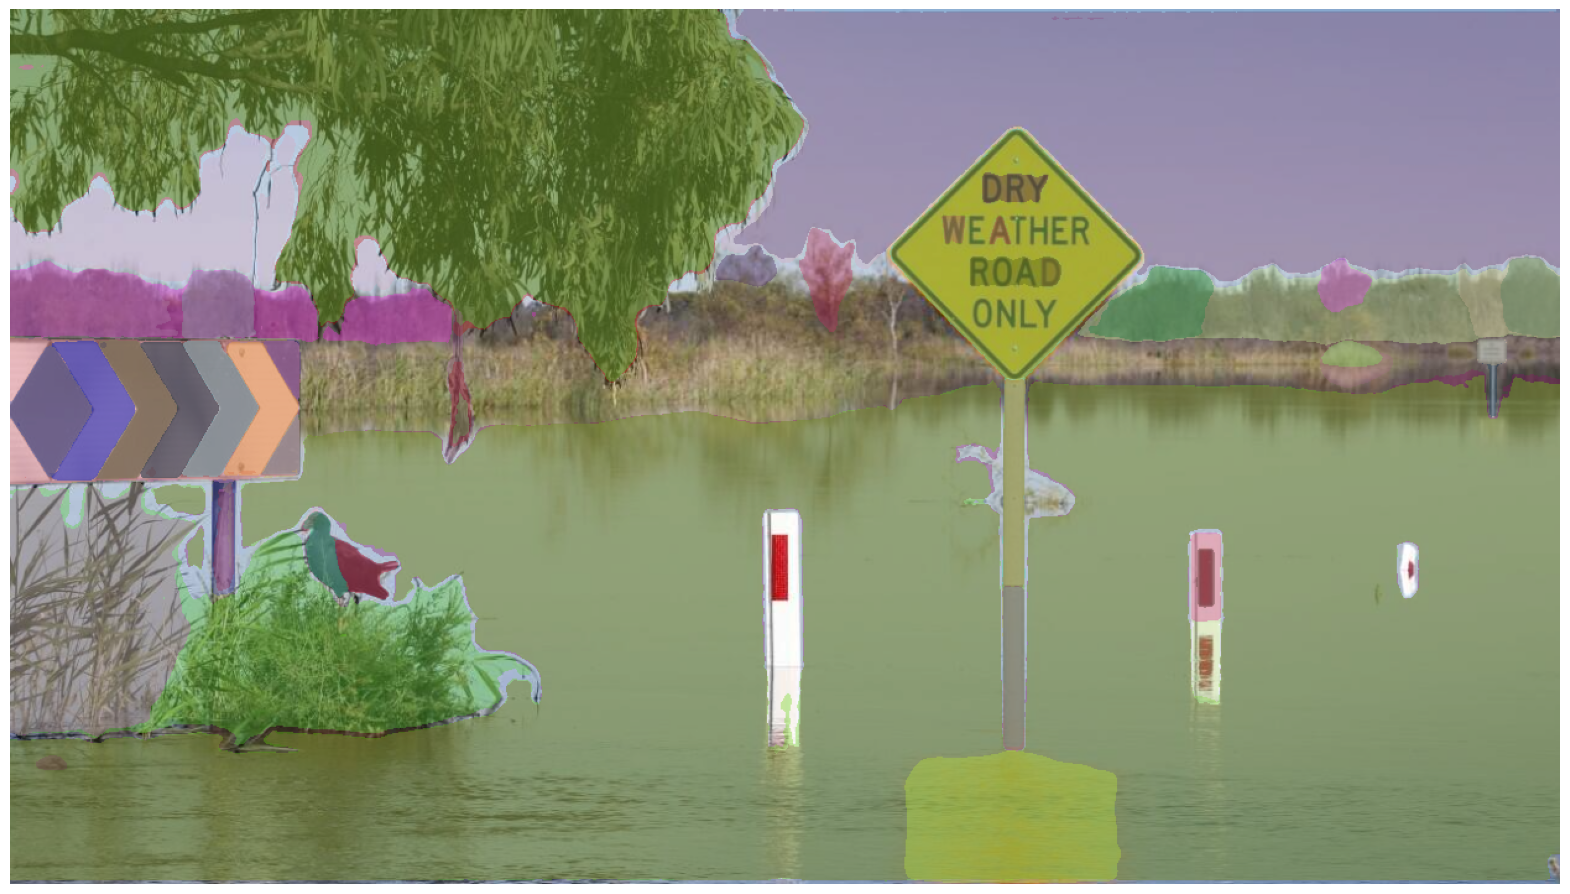

In [70]:
# image = cv2.imread('img.png')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 权重文件保存地址
sam_checkpoint = "model checkpoints/sam_vit_h_4b8939.pth"
# sam_checkpoint = "model_save/sam_vit_h_4b8939.pth"
# sam_checkpoint = "model_save/sam_vit_l_0b3195.pth"
# 模型类型
model_type = "vit_h"
# model_type = "vit_h"
# model_type = "vit_l"
device = "cuda"

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]   # 产生随机颜色的mask
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


In [47]:

def extract_and_save_masked_images(image, masks, output_folder):
    masked_images = []

    for i, ann in enumerate(masks):
        # Create a blank image with the same dimensions as the original
        mask_image = np.zeros_like(image)

        # Extract the segmentation mask
        mask = ann['segmentation']

        # Apply the mask to each color channel of the original image
        for c in range(3):
            mask_image[:, :, c] = image[:, :, c] * mask

        # Save the masked image to a file
        filename = f"{output_folder}/masked_image_{i+1}.jpg"
        cv2.imwrite(filename, cv2.cvtColor(mask_image, cv2.COLOR_RGB2BGR))

        # Store the image in an array if needed elsewhere in your code
        masked_images.append(mask_image)

    return masked_images

# Example usage
# image = cv2.imread('path_to_your_image.jpg')  # Make sure to load your original image
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB if using OpenCV to load image

# Assume 'masks' is a list of mask dictionaries with a 'segmentation' key
# masks = [{'segmentation': mask1}, {'segmentation': mask2}, ...]  # Define your masks here

output_folder = 'result/mask_image1'  # Define the output folder path
masked_images = extract_and_save_masked_images(image, masks, output_folder)

# get result result/mask_image1/masked_image_2.jpg

In [48]:
# select inside points 

def get_bounding_box_coordinates(selected_mask):
    # Find contours from the binary mask
    contours, _ = cv2.findContours(selected_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour (assuming the largest contour is the desired object)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Determine the bounding rectangle for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Top-left corner coordinates
        top_left = (x, y)
        
        # Bottom-right corner coordinates
        bottom_right = (x + w, y + h)
        
        # Print dimensions
        print(f"Width: {w}, Height: {h}")
        
        return top_left, bottom_right
    else:
        return None, None

# Example usage
# Load or define your binary mask (mask should be a binary image with the object as white (255) on a black (0) background)
selected_mask = cv2.imread('result/mask_image1/masked_image_2.jpg', 0)  # Assuming the mask is saved as a grayscale image

top_left, bottom_right = get_bounding_box_coordinates(selected_mask)
if top_left and bottom_right:
    print(f"Top-left corner: {top_left}, Bottom-right corner: {bottom_right}")
    
else:
    print("No contours found.")

Width: 64, Height: 560
Top-left corner: (336, 16), Bottom-right corner: (400, 576)


In [62]:
# select inside and outsidse points

def get_points_inside_and_outside(mask):
    # Find contours from the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Determine the bounding rectangle for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Calculate points inside the contour (centerline points)
        mid_x = x + w // 2 + 10
        point1_y = y + h // 4
        point2_y = y + h // 2
        point3_y = y + (3 * h) // 4
        inside_points = [(mid_x, point1_y), (mid_x, point2_y), (mid_x, point3_y)]
        
        # Calculate points outside the contour
        outside_points = [
            (x - w // 2, y + h // 2),         # Left middle
#             (x + w // 2, y - h // 8),         # Top middle
            (x + (3 * w) // 2, y + h // 2),   # Right middle
#             (x + w // 2, y + (3 * h) // 8),   # Bottom middle
            (x + (6 * w) // 2, y + h // 2),
            (x - w * 4, y )          # Top-left outside
        ]
        
        return inside_points, outside_points
    else:
        print("No contours found.")
        return None, None

# Example usage
# Load your binary mask image
# mask = cv2.imread('path_to_mask_image.jpg', 0)  # Assuming the mask is saved as a grayscale image

inside_points, outside_points = get_points_inside_and_outside(selected_mask)
if inside_points and outside_points:
    # Combine inside and outside points
    combined_points = inside_points + outside_points
    # Convert to numpy array
    input_points = np.array(combined_points)
    print(f"Combined Input Points Array:\n{input_points}")
    
    print(f"Inside Points: {inside_points}")
    print(f"Outside Points: {outside_points}")
else:
    print("No valid object detected.")

Combined Input Points Array:
[[378 156]
 [378 296]
 [378 436]
 [304 296]
 [432 296]
 [528 296]
 [ 80  16]]
Inside Points: [(378, 156), (378, 296), (378, 436)]
Outside Points: [(304, 296), (432, 296), (528, 296), (80, 16)]


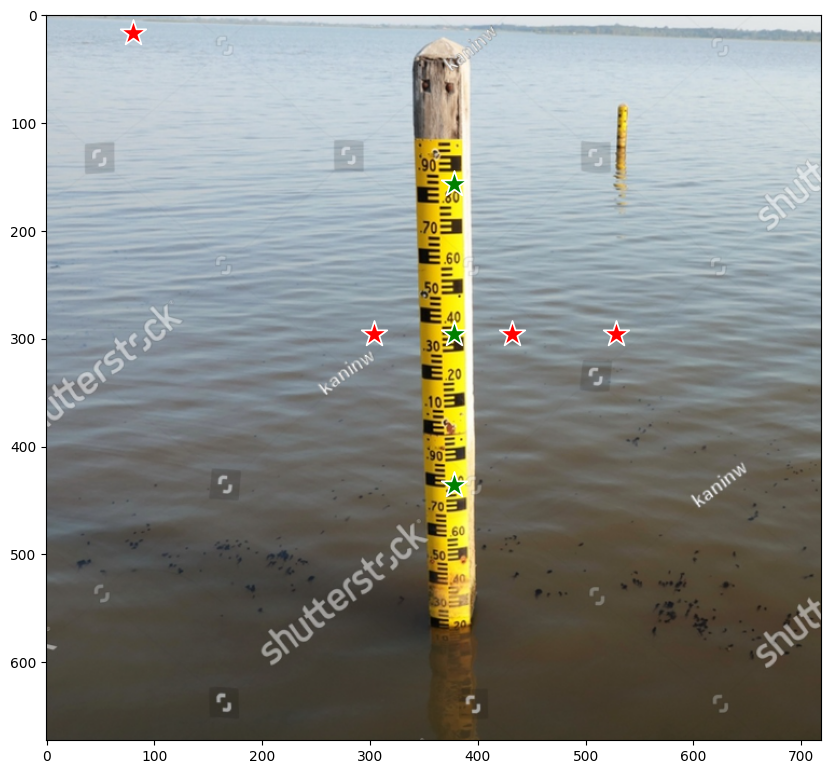

In [63]:
# seed point prompt 

def show_points(coords, labels, ax, marker_size=375):
    # 筛选出前景目标标记点
    pos_points = coords[labels == 1]
    # 筛选出背景目标标记点
    neg_points = coords[labels == 0]
    # x-->pos_points[:, 0] y-->pos_points[:, 1]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)  # 前景的标记点显示
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)  # 背景的标记点显示

# image = cv2.imread('img.png')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 鼠标标定(x,y)位置
# 因为可以有多个标定，所以有多个坐标点
# input_point = np.array([[276, 565], [269, 773], [283, 662], [417, 611], [101, 213]])
# input_point = np.array(inside points, outside points)
# 1表示前景目标，0表示背景
# input_point和input_label一一对应
input_label = np.array([1, 1, 1, 0, 0, 0, 0])

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_points, input_label, plt.gca())
plt.axis('on')
plt.show()


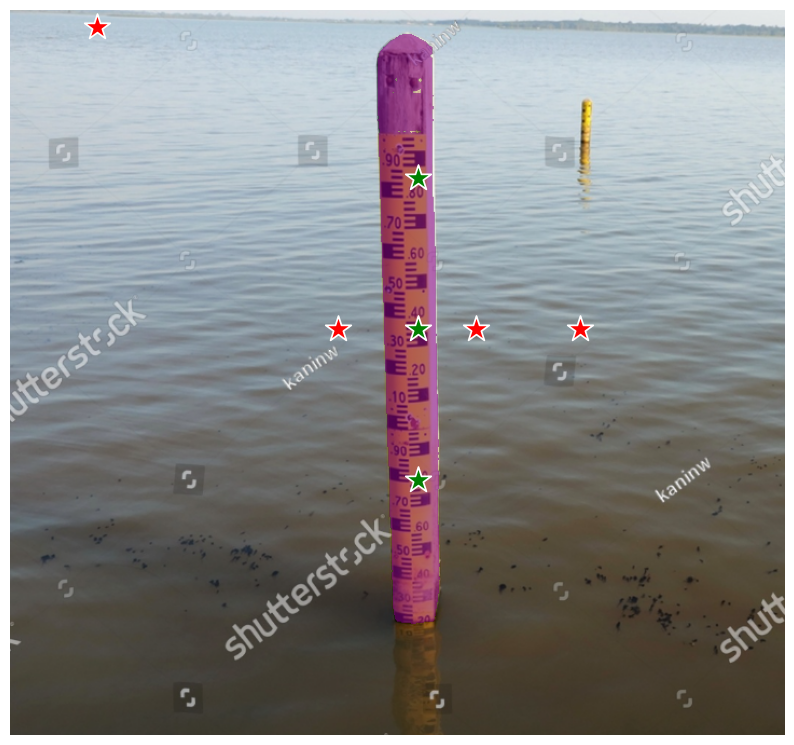

In [64]:
# segment result

def show_mask(mask, ax, random_color=False):
    if random_color:    # 掩膜颜色是否随机决定
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([128 / 255, 0 / 255, 128 / 255, 0.6])
#         color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

    
# image = cv2.imread('img.png')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#------加载模型
# 权重文件保存地址
sam_checkpoint = "model checkpoints/sam_vit_h_4b8939.pth"
# sam_checkpoint = "model_save/sam_vit_h_4b8939.pth"
# sam_checkpoint = "model_save/sam_vit_l_0b3195.pth"
# 模型类型
model_type = "vit_h"
# model_type = "vit_h"
# model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)
#------加载模型


# 标定框和标记点联合使用
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_points(input_points, input_label, plt.gca())
plt.axis('off')
plt.show()


In [65]:
# Assuming 'masks' is a list of masks and 'image' is your image array
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())  # Displays the first mask on the image
plt.axis('off')
plt.savefig('result/mask_image1/mask_final.jpg', bbox_inches='tight', pad_inches=0)  # Saves the figure to a file
plt.close()

In [39]:
final_mask = cv2.imread('result/mask_image1/mask_final.jpg', 0)

top_left, bottom_right = get_bounding_box_coordinates(final_mask)
if top_left and bottom_right:
    print(f"Top-left corner: {top_left}, Bottom-right corner: {bottom_right}")
    
else:
    print("No contours found.")

Width: 515, Height: 770
Top-left corner: (0, 0), Bottom-right corner: (515, 770)


In [66]:
from PIL import Image
import numpy as np

# Assuming 'masks[0]' is your mask array which needs to be binary (0 and 1)
# Convert the binary mask to 0 and 255 for image saving purposes
binary_mask = np.uint8(masks[0] * 255)

# Create an image object from the numpy array
mask_image = Image.fromarray(binary_mask)

# Save the image
mask_image.save('result/mask_image1/binary_mask.jpg')

In [67]:
final_mask = cv2.imread('result/mask_image1/binary_mask.jpg', 0)

top_left, bottom_right = get_bounding_box_coordinates(final_mask)
if top_left and bottom_right:
    print(f"Top-left corner: {top_left}, Bottom-right corner: {bottom_right}")
    
else:
    print("No contours found.")

Width: 64, Height: 560
Top-left corner: (336, 16), Bottom-right corner: (400, 576)
